### Libraries & installation


In [77]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

### Data load
#### we replace ? per NaN for data processing


In [78]:
data = pd.read_csv("/content/diabetic_data.csv", na_values='?') # Precise that ? means NaN here
data_ID = pd.read_csv("/content/IDs_mapping.csv", na_values='?')


### Data Clearing


In [79]:
# Show how much missing value per column
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      data.isna().sum())

# First, we have to delete useless columns or columns that have too many missing values. 
# Then, we will delete useless columns such as weight, payer_code, encounter_id, patient_nbr

data.drop(['encounter_id','patient_nbr','weight','payer_code'],axis=1,inplace=True)

# Moreover, we'll have to delete rows missing values for diag_1, diag_2, diag_3 and for medical_specialty (which is a pretty good feature)
data = data.dropna()

#Yes, we delete lots of rows, but we still have a database of >40 000 which is pretty great

 
Count total NaN at each column in a DataFrame : 

 encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide               

### We replace qualitative value par quantitative value for machine learning

In [80]:

# AGE 
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
# discharge disposition id 

data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])] #If we look at the IDs_mapping.csv provided by UCI we can see that 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model since they cannot be readmitted.

data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

# There are lots of useless columns in there, we will see that after.
for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))

#If change of the process or not
data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)


data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

# medical_specialty add 0.02 accuracy even if lots of values are unknown
data['medical_specialty'] = data['medical_specialty'].apply(lambda x : 1 if x == 'InternalMedicine' 
                                                            else ( 2 if x == 'Emergency/Trauma'                                                          
                                                            else ( 3 if x == 'Family/GeneralPractice'
                                                            else ( 4 if x == 'Cardiology'
                                                            else ( 5 if x == 'Surgery-General'
                                                            else ( 6 if x == 'Nephrology'
                                                            else ( 7 if x == 'Orthopedics'
                                                            else ( 8 if x == 'Orthopedics-Reconstructive'
                                                            else ( 9 if x == 'Radiologist'
                                                            else  0)))))))))

#data['medical_specialty'] = data['medical_specialty'].apply(lambda x : 1 if x in ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive','Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist'] 
#                                                           else ( 2 if x in ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology','Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']                                                         
#                                                           else ( 3 if x in ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology','Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent','Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric','Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices','Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']
#                                                           else ( 4 if x in ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']
#                                                           else ( 5 if x in ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']
#                                                           else ( 6 if x in ['Surgeon', 'Surgery-Cardiovascular','Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial','Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic','Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
#                                                           else ( 7 if x in ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases','Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']
#                                                           else  0)))))))

# It's a very bad idea to regroup like this, because we'll have over 40 000 on family 1... Then we only the top 10 medical specialty

# RACE 
replaceDictRace = {'Caucasian' : 0,
'AfricanAmerican' : 1,
'Hispanic' : 2, 
'Other' : 3, 
'Asian' : 4}

data['race'] = data['race'].apply(lambda x : replaceDictRace[x])

# GENDER 
replaceDictGender = {'Female' : 0,
'Male' : 1,
'Unknown/Invalid' : 2}

data['gender'] = data['gender'].apply(lambda x : replaceDictGender[x])

# CLASSIFICATOR 
replaceDictreadmitted = {'NO' : 0,
'>30' : 30,
'<30' : -30}
# READMITTED 
data['readmitted'] = data['readmitted'].apply(lambda x : replaceDictreadmitted[x])

data['diag_1'] = data['diag_1'].apply(lambda x : '0' if (str(x).find('V') != -1 or str(x).find('E') != -1) # str will count the number of the string. if it contain V or E, x = 0 
                                        else ('1' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('2' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('3'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('4'    if int(float(x)) == 250
                                        else     ('5'      if int(float(x)) in range(800, 1000)
                                        else ('6' if int(float(x)) in range(710, 740)
                                        else ('7'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('8'       if int(float(x)) in range(140, 240)
                                        else ('9'        if int(float(x)) in range(630, 680)
                                        else '0'))))))))))
data['diag_2'] = data['diag_2'].apply(lambda x : '0' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('1' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('2' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('3'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('4'    if int(float(x)) == 250
                                        else     ('5'      if int(float(x)) in range(800, 1000)
                                        else ('6' if int(float(x)) in range(710, 740)
                                        else ('7'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('8'       if int(float(x)) in range(140, 240)
                                        else ('9'        if int(float(x)) in range(630, 680)
                                        else '0'))))))))))
data['diag_3'] = data['diag_3'].apply(lambda x : '0' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('1' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('2' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('3'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('4'    if int(float(x)) == 250
                                        else     ('5'      if int(float(x)) in range(800, 1000)
                                        else ('6' if int(float(x)) in range(710, 740)
                                        else ('7'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('8'       if int(float(x)) in range(140, 240)
                                        else ('9'        if int(float(x)) in range(630, 680)
                                        else '0'))))))))))



### Data processing Machine Learning

#### We decided to scale the data with MinMaxScaler(). the minimum of the column will be = 0 while le max = 1

In [81]:
X = data.copy(deep=True) # And any modification on X won't affect our original dataframe
del X["readmitted"]# Our dataframe without classification column
y=data['readmitted']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 70% training and 30% test


### Random Forest 

In [66]:
clf=RandomForestClassifier(n_estimators=400)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix
print("\n\n\n matrix of confusion : \n\n\n", confusion_matrix(y_test,y_pred))
print("\n\n\n classification report : \n\n\n" ,classification_report(y_test,y_pred))


Accuracy: 0.5670482420278005



 matrix of confusion : 


 [[  12  354  192]
 [   8 2211  388]
 [  11 1165  551]]



 classification report : 


               precision    recall  f1-score   support

         -30       0.39      0.02      0.04       558
           0       0.59      0.85      0.70      2607
          30       0.49      0.32      0.39      1727

    accuracy                           0.57      4892
   macro avg       0.49      0.40      0.37      4892
weighted avg       0.53      0.57      0.51      4892



### Hyperparameters optimisation

#### We did a really huge work on hyperparameters. First, we limit our data by 10 000 for easier calculation. 

In [ ]:
#Sampled X because too heavy for research of 
from random import sample
data_sample = data.copy(deep=True)
data_sample = data_sample.sample(n = 10000)
X_sample = data_sample.copy(deep=True) # And any modification on X won't affect our original dataframe
del X_sample["readmitted"] # Our dataframe without classification column
y_sample=data_sample['readmitted']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_sample = pd.DataFrame(scaler.fit_transform(X_sample), columns=X.columns)
# Split dataset into training set and test set
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.1) # 70% training and 30% test

#### Here we will generate a combinaison between lots of parameters, we will generate a thousand randomly and we will see what are the best parameters 

In [ ]:
from random import sample

n_estimators = [200,500,800,1500,2500,5000]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [5, 10, 20, 30, 40, 50]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20, 30, 40]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25]

grid_param = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

from sklearn.model_selection import RandomizedSearchCV
RFC = RandomForestClassifier(random_state=1)
RFC_random = RandomizedSearchCV(estimator = RFC, param_distributions = grid_param, n_iter = 20, cv = 5, verbose = 2, random_state=42, n_jobs  = -1)

RFC_random.fit(X_train_sample,y_train_sample)
print(RFC_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
y_pred=RFC_random.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


NotFittedError: ignored

Index(['race', 'gender', 'age', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'insulin'],
      dtype='object')


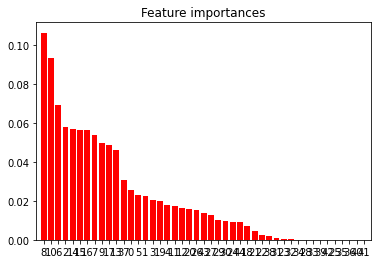

In [ ]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)
#pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [75]:
data_API = data[['race', 'gender', 'age', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'insulin', 'readmitted']].copy()




 0     26597
 30    16894
-30     5423
Name: readmitted, dtype: int64

In [60]:
X = data.copy(deep=True) # And any modification on X won't affect our original dataframe
del X["readmitted"]# Our dataframe without classification column
y=data['readmitted']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 70% training and 30% test

In [76]:
clf=RandomForestClassifier(n_estimators=2500, min_samples_split = 10, min_samples_leaf = 1, max_features = 'auto', max_depth =20)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Accuracy: 0.5746116107931316
[[  10  357  191]
 [   3 2278  326]
 [   6 1198  523]]
              precision    recall  f1-score   support

         -30       0.53      0.02      0.03       558
           0       0.59      0.87      0.71      2607
          30       0.50      0.30      0.38      1727

    accuracy                           0.57      4892
   macro avg       0.54      0.40      0.37      4892
weighted avg       0.55      0.57      0.51      4892



### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [ ]:
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

[[  12  304  180]
 [   5 2308  375]
 [  10 1157  541]]
              precision    recall  f1-score   support

         -30       0.44      0.02      0.05       496
           0       0.61      0.86      0.71      2688
          30       0.49      0.32      0.39      1708

    accuracy                           0.58      4892
   macro avg       0.52      0.40      0.38      4892
weighted avg       0.55      0.58      0.53      4892

Accuracy: 0.5848323793949305


###Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.5940310711365495